In [1]:
import pandas as pd
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 350)

In [3]:
data=pd.read_csv("https://drive.google.com/uc?export=download&id=1LU5be_H1TD2Pp1OmI202to3YyKo9AzFY")

In [4]:
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


## Goal: To increase conversion rate: # of conversions / total sessions

#### 1. Descriptive Statistics - Get to know the dataset

In [5]:
data.describe()

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


In [7]:
data.groupby(['country']).size() #count by country

country
China       76602
Germany     13056
UK          48450
US         178092
dtype: int64

In [8]:
data.groupby(['source']).size() #count by marketing channel source

source
Ads        88740
Direct     72420
Seo       155040
dtype: int64

In [10]:
print(sorted(data['age'].unique(), reverse=True)) # investigate in the age

[123, 111, 79, 77, 73, 72, 70, 69, 68, 67, 66, 65, 64, 63, 62, 61, 60, 59, 58, 57, 56, 55, 54, 53, 52, 51, 50, 49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17]


In [11]:
print(data[data['age']>110])

        country  age  new_user source  total_pages_visited  converted
90928   Germany  123         0    Seo                   15          1
295581       UK  111         0    Ads                   10          1


In [12]:
data = data[data['age']<110] # remove the two rows with age > 110

#### 2. Data Visualization

In [13]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

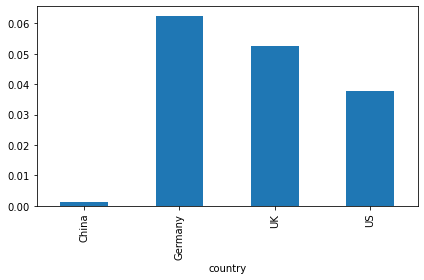

In [17]:
data.groupby(['country'])['converted'].mean().plot.bar()
plt.show()
# China has the lowest conversion rate comparing to the other countries

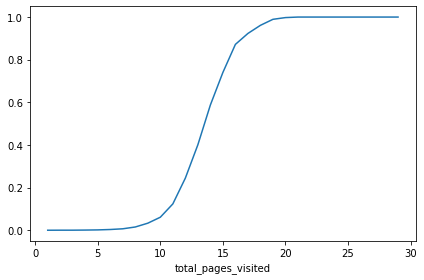

In [18]:
data.groupby(['total_pages_visited'])['converted'].mean().plot()
plt.show()
#more pages visited implies higher probability of conversion

#### 3. Machine Learning - Random Forest

I am going to pick a random forest to predict conversion rate. I picked a random forest because: it usually requires very little time to optimize it (its default params are often close to be the best ones) and it is strong with outliers, irrelevant variables, continuous and discrete variables. I will use the random forest to predict conversion, then I will use its partial dependence plots and variable importance to get insights. Also, I will build a simple tree to find the most obvious user segments.

In [19]:
data_dummy = pd.get_dummies(data, drop_first=True)

In [20]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier

In [21]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [22]:
np.random.seed(4684)
train, test = train_test_split(data_dummy, test_size = 0.34)

In [24]:
# build the model
rf = RandomForestClassifier(n_estimators=100, max_features=3, oob_score=True)
rf.fit(train.drop('converted', axis=1), train['converted'])

RandomForestClassifier(max_features=3, oob_score=True)

In [26]:
print(
"OOB accuracy is", 
rf.oob_score_, 
"\n", 
"OOB Confusion Matrix", 
"\n",
pd.DataFrame(confusion_matrix(train['converted'], rf.oob_decision_function_[:,1].round(), labels=[0, 1]))
)

OOB accuracy is 0.9838851885571901 
 OOB Confusion Matrix 
         0     1
0  200872  1102
1    2261  4455


In [27]:
print(
"Test accuracy is", rf.score(test.drop('converted', axis=1),test['converted']), 
"\n", 
"Test Set Confusion Matrix", 
"\n",
pd.DataFrame(confusion_matrix(test['converted'], rf.predict(test.drop('converted', axis=1)), labels=[0, 1]))
)

Test accuracy is 0.9847360196450496 
 Test Set Confusion Matrix 
         0     1
0  103483   543
1    1098  2384


Since OOB error and test error are pretty similar, we are confident the model is not overfitting. 

Now, I want to check variable importance in the Random Forest Model

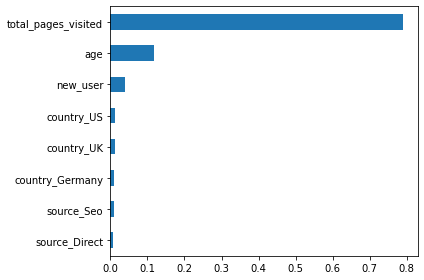

In [28]:
feature_importance = pd.Series(rf.feature_importances_, index=train.drop('converted', axis=1).columns)
feature_importance.sort_values().plot(kind='barh')
plt.show()
# total_pages_visited is the most important one, but we can't do that many things about it since it shows the customer's intention to buy

Let’s rebuild the RF without that variable. Since classes are heavily unbalanced and we don’t have that very powerful variable anymore, let’s change the weights, just to make sure we will get something classified as 1.

In [29]:
rf = RandomForestClassifier(n_estimators=100, max_features=3, oob_score=True, class_weight={0:1, 1:10})
rf.fit(train.drop(['converted', 'total_pages_visited'], axis=1), train['converted'])

RandomForestClassifier(class_weight={0: 1, 1: 10}, max_features=3,
                       oob_score=True)

In [30]:
print(
"OOB accuracy is", 
rf.oob_score_, 
"\n", 
"OOB Confusion Matrix", 
"\n",
pd.DataFrame(confusion_matrix(train['converted'], rf.oob_decision_function_[:,1].round(), labels=[0, 1]))
)

OOB accuracy is 0.889827016148354 
 OOB Confusion Matrix 
         0      1
0  182720  19254
1    3738   2978


In [31]:
print(
"Test accuracy is", rf.score(test.drop(['converted', 'total_pages_visited'], axis=1),test['converted']), 
"\n", 
"Test Set Confusion Matrix", 
"\n",
pd.DataFrame(confusion_matrix(test['converted'], rf.predict(test.drop(['converted', 'total_pages_visited'], axis=1)), labels=[0, 1]))
)

Test accuracy is 0.8899802805372623 
 Test Set Confusion Matrix 
        0     1
0  94140  9886
1   1942  1540


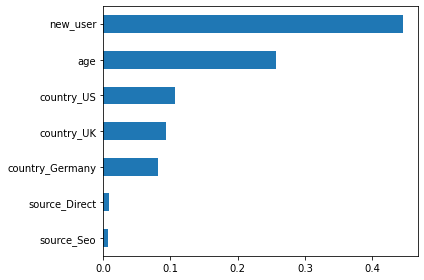

In [32]:
feature_importances = pd.Series(rf.feature_importances_, index=train.drop(['converted', 'total_pages_visited'], axis=1).columns)
feature_importances.sort_values().plot(kind='barh')
plt.show()
# Now, new_user becomes the most important feature. Source related dummies don't seem to matter at all.

#### 4. Partial Dependence Plots (PDP)

In [34]:
from pdpbox import pdp, info_plots

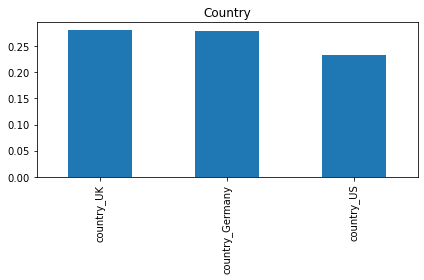

In [35]:
pdp_iso = pdp.pdp_isolate(model=rf, dataset=train.drop(['converted', 'total_pages_visited'], axis=1), 
                         model_features=list(train.drop(['converted', 'total_pages_visited'], axis=1)),
                         feature=['country_Germany', 'country_UK', 'country_US'],
                         num_grid_points=50)
pdp_dataset = pd.Series(pdp_iso.pdp, index=pdp_iso.display_columns)
pdp_dataset.sort_values(ascending=False).plot(kind='bar', title='Country')
plt.show()

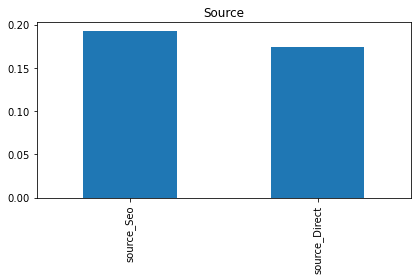

In [37]:
pdp_iso = pdp.pdp_isolate( model=rf, 
                          dataset=train.drop(['converted', 'total_pages_visited'], axis=1),      
                          model_features=list(train.drop(['converted', 'total_pages_visited'], axis=1)), 
                          feature=['source_Direct', 'source_Seo'], 
                          num_grid_points=50)
pdp_dataset = pd.Series(pdp_iso.pdp, index=pdp_iso.display_columns)
pdp_dataset.sort_values(ascending=False).plot(kind='bar', title='Source')
plt.show()

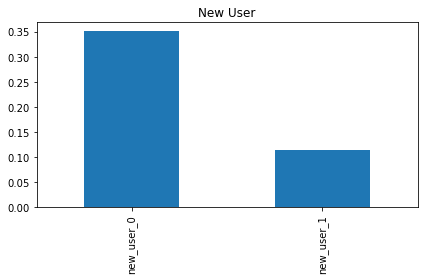

In [38]:
pdp_iso = pdp.pdp_isolate( model=rf, 
                          dataset=train.drop(['converted', 'total_pages_visited'], axis=1),      
                          model_features=list(train.drop(['converted', 'total_pages_visited'], axis=1)), 
                          feature='new_user', 
                          num_grid_points=50)
pdp_dataset = pd.Series(pdp_iso.pdp, index=pdp_iso.display_columns)
pdp_dataset.sort_values(ascending=False).plot(kind='bar', title='New User')
plt.show()

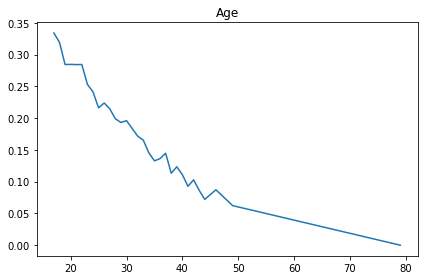

In [39]:
pdp_iso = pdp.pdp_isolate( model=rf, 
                          dataset=train.drop(['converted', 'total_pages_visited'], axis=1),      
                          model_features=list(train.drop(['converted', 'total_pages_visited'], axis=1)), 
                          feature='age', 
                          num_grid_points=50)
pdp_dataset = pd.Series(pdp_iso.pdp, index=pdp_iso.feature_grids)
pdp_dataset.plot(title='Age')
plt.show()

#### 5. Insights
- Old users perform much better than new users

- Germany, UK, and US are similar, with Germany being the best. Most importantly, they all have very very high values. We could read this as relative to the reference level, which is China. So this means that not being from China and being from any of those 3 countries significantly increases the probability of conversion. That is, China is very bad for conversion

- The site works very well for young people and gets worse for >30 yr old

- Source is less relevant. SEO is slightly better than direct

#### 6. Use a Decision Tree to identity important segments

In [47]:
import graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from graphviz import Source

In [48]:
tree = DecisionTreeClassifier( max_depth=2,class_weight={0:1, 1:10}, min_impurity_decrease = 0.001)
tree.fit(train.drop(['converted', 'total_pages_visited'], axis=1), train['converted'])

DecisionTreeClassifier(class_weight={0: 1, 1: 10}, max_depth=2,
                       min_impurity_decrease=0.001)

In [50]:
export_graphviz(tree, out_file="tree_conversion.dot", feature_names=train.drop(['converted', 'total_pages_visited'], axis=1).columns, proportion=True, rotate=True)
with open("tree_conversion.dot") as f:
    dot_graph = f.read()
  
s = Source.from_file("tree_conversion.dot")
s.view()

'tree_conversion.dot.pdf'

#### 7. Product Insights

- Younger people have a higher conversion rate. Ask the marketing team to advertise and use channelsto reach to more young people
- There's something wrong with the Chinese verion of the site. There are a lot of users from China but the conversion rate is extremely low comparing to the other countries. We want to have a tea to check the translation of the website and see if the site is localized to the Chinese culture
- Germany shows the highest converion rate, but there are fewGermans coming to the site, We should have the marketing team target more German customers
- Old users have a uch higher conversion rate. We should launch a marketing campaign to offer prmotions to old users and bring back more old users
- Want to figure out why the conversion rate for the older users are dropping so quickly and becoming so low. might want to check the UI